In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
#import matplotlib
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
#%matplotlib notebook
import scipy.special as special
df = np.loadtxt('data/usincmoms.txt') 

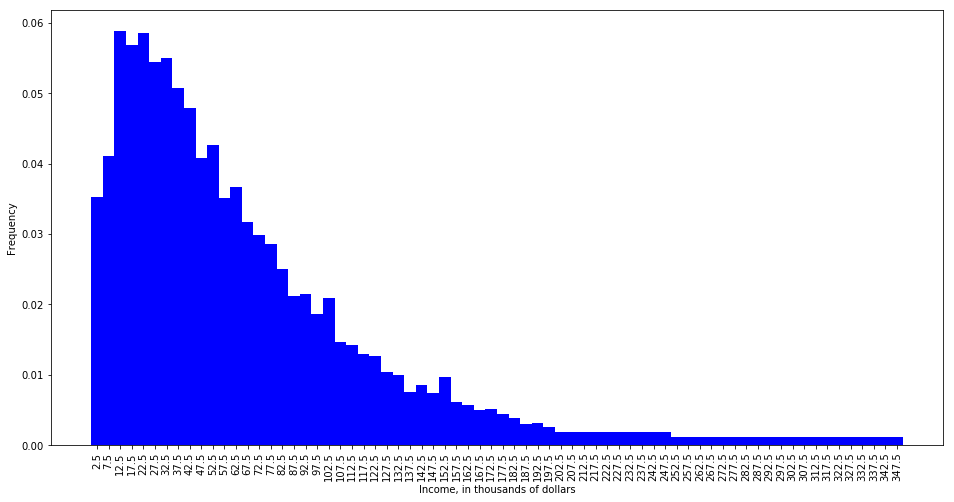

In [2]:
# plotting the moments
second_last_freq = df[-2, 0]/10
last_freq = df[-1, 0]/20
data_graphing = df[:-2,]
replace = np.zeros((30, 2))
replace[:10, 0] = second_last_freq
replace[10:, 0] = last_freq
replace[:10, 1] = np.linspace(202500, 247500, 10)
replace[10:, 1] = np.linspace(252500, 347500, 20)
data_graphing = np.concatenate((data_graphing, replace), axis=0)
data_graphing[:, 1] *= (1/1000)
#plotting
fig = plt.figure(figsize=(16, 8))
pos = np.arange(len(data_graphing[:,0]))
wid = 5
plt.bar(data_graphing[:, 1], data_graphing[:, 0], width = wid, color = 'b')
plt.xticks(data_graphing[:,1], data_graphing[:,1], rotation = 'vertical')
plt.xlabel("Income, in thousands of dollars")
plt.ylabel("Frequency")
plt.show()

In [3]:
## GMM estimation 
moms_data = data_graphing[:, 0]*(1/wid)

def lognorm_dist(xvals, mu, sigma):
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))))
    pdf_vals[np.isclose(pdf_vals, np.zeros_like(pdf_vals), atol = 1e-25)] = 1e-24
    
    return pdf_vals

def err_vec_LN(xvals, mu, sigma, moms_data, simple):
    moms_model = lognorm_dist(xvals, mu, sigma)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data)/moms_data
    return err_vec

def crit_LN(params, *args):
    mu, sigma = params
    xvals, moms_data, W, simple = args
    err = err_vec_LN(xvals, mu, sigma, moms_data, simple)
    crit_val = abs(np.dot(np.dot(err.T, W), err))
    
    return crit_val

# initialization and estimation
mu_init = (data_graphing[:, 0]*data_graphing[:,1]).sum()
sigma_init = 100
bnds = ((1e-5, None), (1e-5, None))
params_init = (mu_init, sigma_init)
W = np.diag(data_graphing[:, 0])
gmm_args = data_graphing[:, 1], moms_data, W, False
results_LN = opt.minimize(crit_LN, params_init, args=(gmm_args),
                           method='L-BFGS-B', bounds = bnds)
print(results_LN)
mu_LN, sigma_LN = results_LN.x

      fun: 0.04182845299694387
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.16413562e-07,  -5.97438765e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 171
      nit: 16
   status: 0
  success: True
        x: array([ 3.89185634,  0.97776658])


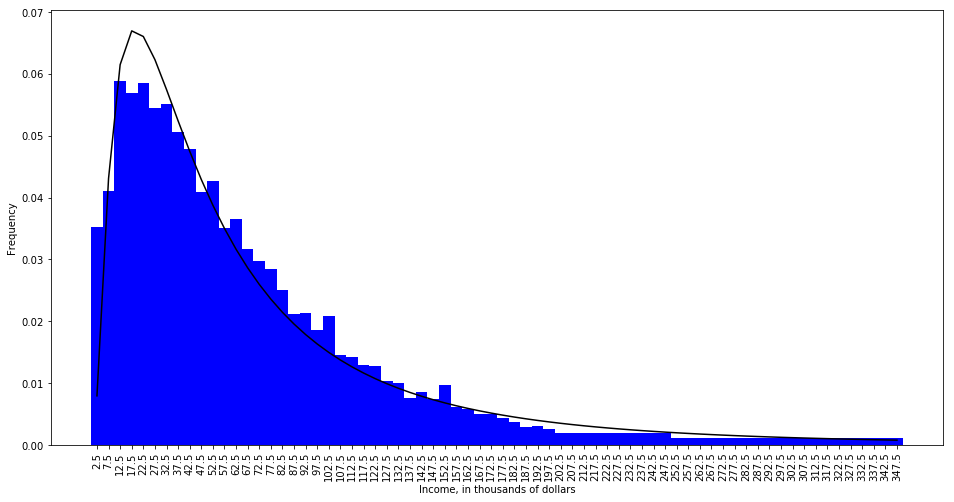

In [4]:
#plotting
wid = 5
fig_LN = plt.figure(figsize=(16, 8))
inc = np.linspace(2.5, 347.5, 70)
pdf_star = lognorm_dist(inc, mu_LN, sigma_LN)*wid
plt.plot(inc, pdf_star, "k-")
#pos = np.arange(len(data_graphing[:,0]))

plt.bar(data_graphing[:, 1], data_graphing[:, 0], width = wid, color = 'b')
plt.xticks(data_graphing[:,1], data_graphing[:,1], rotation = 'vertical')
plt.xlabel("Income, in thousands of dollars")
plt.ylabel("Frequency")
plt.show()

In [5]:
# GA distribution
moms_data = data_graphing[:, 0]*(1/5)

def GA_dist(xvals, alpha, beta):
    '''
    ----------------------------
    GA distribution function
    ----------------------------
    '''
    pdf_vals = 1/((beta**alpha)*special.gamma(alpha))*(xvals**(alpha - 1))*np.exp(-xvals/beta)
    pdf_vals[np.isclose(pdf_vals, np.zeros_like(pdf_vals), atol = 1e-30)] = 1e-29
    return pdf_vals
def err_vec_GA(xvals, alpha, beta, moms_data, simple):
    moms_model = GA_dist(xvals, alpha, beta)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data)/moms_data
    return err_vec

def crit_GA(params, *args):
    alpha, beta = params
    xvals, moms_data, W, simple = args
    err = err_vec_GA(xvals, alpha, beta, moms_data, simple)
    crit_val = abs(np.dot(np.dot(err.T, W), err))
    
    return crit_val

# initialization and estimation
alpha_init = 1
beta_init = 50
bnds = ((1e-5, None), (1e-5, None))
params_init = (alpha_init, beta_init)
W = np.diag(data_graphing[:, 0])
gmm_args = data_graphing[:, 1], moms_data, W, False
results_GA = opt.minimize(crit_GA, params_init, args=(gmm_args),
                           method='L-BFGS-B', bounds = bnds)
print(results_GA)
alpha_GA, beta_GA = results_GA.x

      fun: 0.017071394404916201
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.22044605e-08,  -3.46944695e-10])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 18
   status: 0
  success: True
        x: array([  1.3935243 ,  46.85365604])


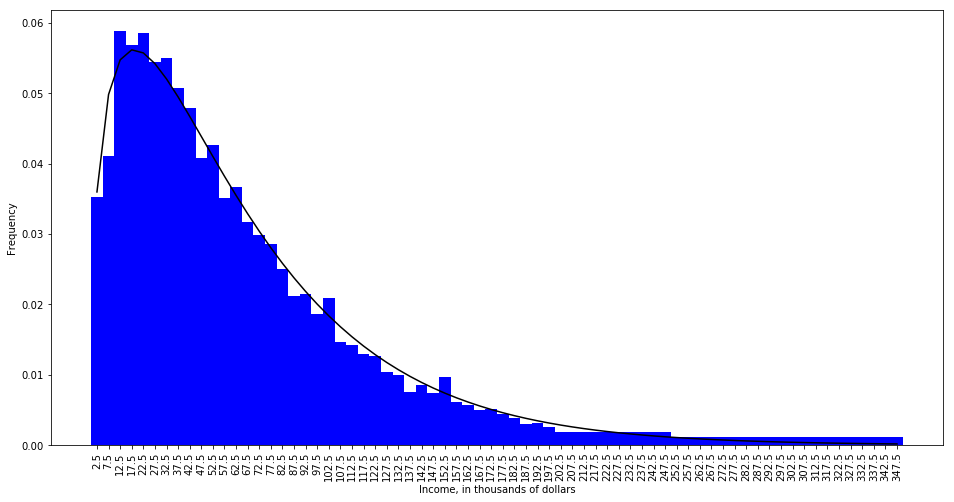

In [6]:
#plotting
wid = 5
fig_GA = plt.figure(figsize=(16, 8))
inc = np.linspace(2.5, 347.5, 70)
pdf_star = GA_dist(inc, alpha_GA, beta_GA)*wid
plt.plot(inc, pdf_star, "k-")
#pos = np.arange(len(data_graphing[:,0]))

plt.bar(data_graphing[:, 1], data_graphing[:, 0], width = wid, color = 'b')
plt.xticks(data_graphing[:,1], data_graphing[:,1], rotation = 'vertical')
plt.xlabel("Income, in thousands of dollars")
plt.ylabel("Frequency")
plt.show()

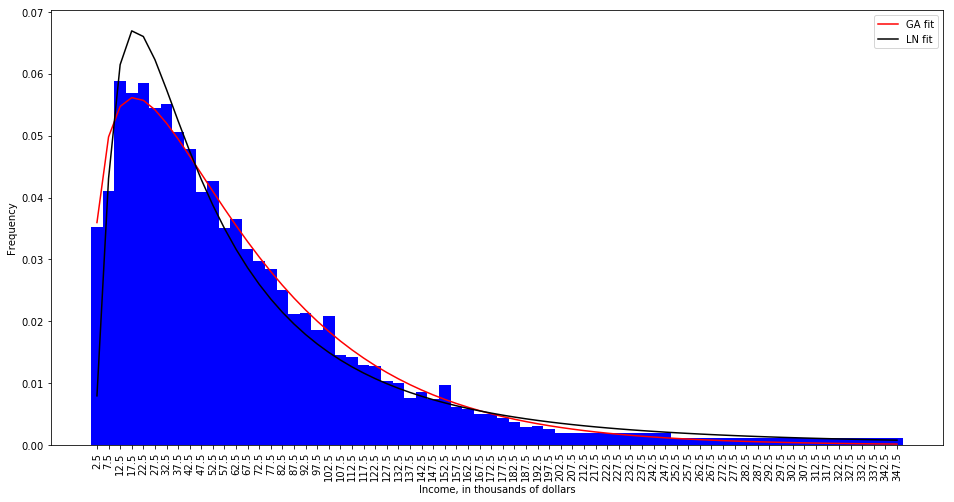

In [7]:
#comparison plotting
wid = 5
fig_compare = plt.figure(figsize=(16, 8))
inc = np.linspace(2.5, 347.5, 70)
pdf_star = GA_dist(inc, alpha_GA, beta_GA)*wid
plt.plot(inc, pdf_star, "r-", label = "GA fit")
inc = np.linspace(2.5, 347.5, 70)
pdf_star = lognorm_dist(inc, mu_LN, sigma_LN)*wid
plt.plot(inc, pdf_star, "k-", label = "LN fit")
plt.legend()
#pos = np.arange(len(data_graphing[:,0]))

plt.bar(data_graphing[:, 1], data_graphing[:, 0], width = wid, color = 'b')
plt.xticks(data_graphing[:,1], data_graphing[:,1], rotation = 'vertical')
plt.xlabel("Income, in thousands of dollars")
plt.ylabel("Frequency")
plt.show()

According to the function value in both estimation, we found that the GA distribution fits the original data better.

In [8]:
# 2-step weighting matrix
# Step 1 
# To calculate the paramters bsaed on identity weighting matrix
moms_data = data_graphing[:, 0]*(1/wid)

# initialization and estimation
alpha_init = 1
beta_init = 10
bnds = ((1e-5, None), (1e-5, None))
params_init = (alpha_init, beta_init)
W = np.diag(data_graphing[:, 0])
gmm_args = data_graphing[:, 1], moms_data, W, False
results_1step = opt.minimize(crit_GA, params_init, args=(gmm_args),
                           method='L-BFGS-B', bounds = bnds)
print(results_1step)
alpha_GA_stp1, beta_GA_stp1 = results_1step.x
err_stp1 = err_vec_GA(data_graphing[:, 1], alpha_GA_stp1, beta_GA_stp1, moms_data, False)

      fun: 0.017071394631048266
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.03992942e-06,  -4.03843625e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 18
   status: 0
  success: True
        x: array([  1.39354825,  46.85235508])


In [23]:
# Now we proceed to the second step
omega2 = (1/len(err_stp1))*np.outer(err_stp1,err_stp1)
W2 = np.linalg.pinv(omega2)
#W2 = np.linalg.pinv(results.hess_inv.todense())
# start the second estimation step
#for alpha_init in np.linspace()
alpha_init = 1.8
beta_init = 70
bnds = ((1e-5, None), (1e-5, None))
params_init = (alpha_init, beta_init)
gmm_args = data_graphing[:, 1], moms_data, W2, False
results_2step = opt.minimize(crit_GA, params_init, args=(gmm_args),
                           method='L-BFGS-B', bounds = bnds)
print(results_2step)
alpha_GA_stp2, beta_GA_stp2 = results_2step.x


      fun: 1.2389127700800044e-15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.00347946e-06,  -1.19002272e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 8
   status: 0
  success: True
        x: array([  1.43354774,  64.5187111 ])


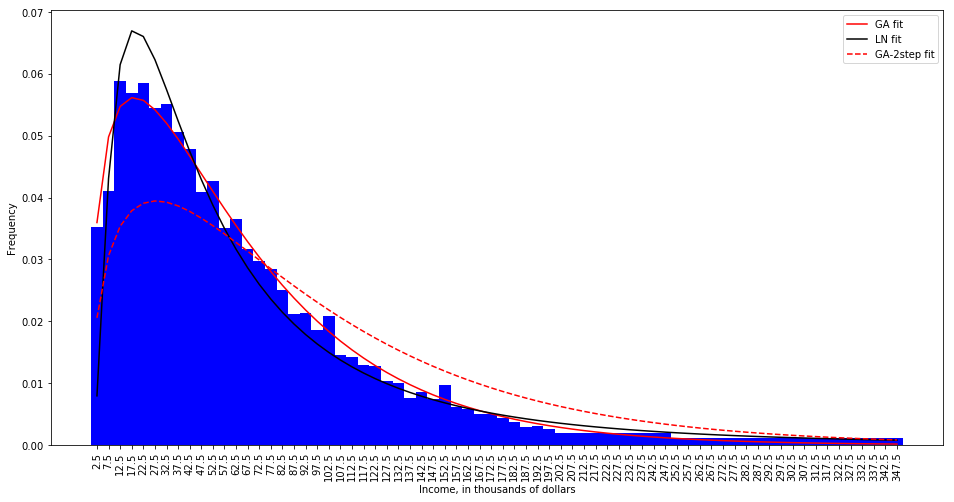

In [24]:

#comparison plot
wid = 5
fig_compareAll = plt.figure(figsize=(16, 8))
inc = np.linspace(2.5, 347.5, 70)

pdf_star1 = GA_dist(inc, alpha_GA, beta_GA)*wid
plt.plot(inc, pdf_star1, "r-", label = "GA fit")

pdf_star2 = lognorm_dist(inc, mu_LN, sigma_LN)*wid
plt.plot(inc, pdf_star2, "k-", label = "LN fit")

pdf_star3 = GA_dist(inc, alpha_GA_stp2, beta_GA_stp2)*wid
plt.plot(inc, pdf_star3, "r--", label = "GA-2step fit")
plt.legend()
#pos = np.arange(len(data_graphing[:,0]))

plt.bar(data_graphing[:, 1], data_graphing[:, 0], width = wid, color = 'b')
plt.xticks(data_graphing[:,1], data_graphing[:,1], rotation = 'vertical')
plt.xlabel("Income, in thousands of dollars")
plt.ylabel("Frequency")
plt.show()

In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
